In [1]:
from scipy.integrate import odeint
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
# from helpers.plot import plotter
import matplotlib.dates as mdates


from scipy import stats as sps
from datetime import datetime, timedelta

In [2]:
def R0_t(t, b, r_s):
    return (2 / np.pi) * np.arctan(-(t - b) / 20 * r_s) + 1

def deriv(y, t, N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, beds):
    S, E, L, I, C, R, D = y
    dSdt = -beta(t) * S * (I + L) / N
    dEdt = beta(t) * S * (I + L) / N - delta * E
    dLdt = delta * E - epsilon * p_L_to_R * L - theta * (1 - p_L_to_R) * L
    dIdt = theta * (1 - p_L_to_R) * L - gamma * (1 - p_I_to_C) * I  - lamda * p_I_to_C * I
    dCdt = lamda * p_I_to_C * I - tau * (1 - p_C_to_D) * min(beds(t), C) - rho * p_C_to_D * min(beds(t), C) \
           - max(0, C - beds(t))
    dRdt = gamma * (1 - p_I_to_C) * I + tau * (1 - p_C_to_D) * min(beds(t), C) + epsilon * p_L_to_R * L
    dDdt = rho * p_C_to_D * min(beds(t), C) + max(0, C-beds(t))
    return dSdt, dEdt, dLdt, dIdt, dCdt, dRdt, dDdt

def Model(days, agegroups, beds_per_100k, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s):

    def beta(t):
        return alpha*R0_t(t, b, r_s)

    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days, days)
    ret = odeint(deriv, y0, t, args=(N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, Beds))
    S, E, L, I, C, R, D = ret.T
    R_0_over_time = [beta(i) for i in range(len(t))]


    return t, S, E, L, I, C, R, D, R_0_over_time, Beds, p_I_to_C, p_C_to_D

# Hyperparameters

In [3]:
gamma = 1.0 / 9.0 # 9 days from infection to recovery
delta = 1.0 / 2.0  # incubation period of two days
epsilon = 1.0 / 7.0 # a week for latent person to recover
theta = 1.0 / 3.0 # three days for latent to show symptoms
lamda = 1.0 / 5.0 # five days for infected to be critical
tau = 1.0 / 6.5 # week for critical patients to recover
rho = 1.0 / 7.5 # 7.5 days from critical to death

In [4]:
## Load DATA

beds = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/beds.csv", header=0)
agegroups = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/agegroups.csv")
probabilities = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/probabilities.csv")
covid_data = pd.read_csv("https://tinyurl.com/t59cgxn", parse_dates=["Date"], skiprows=[1])
covid_data["Location"] = covid_data["Country/Region"]
# covid_data["Location"].unique()

# create some dicts for fast lookup
# 1. beds
beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
# 2. agegroups
agegroup_lookup = dict(zip(agegroups['Location'], agegroups[['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_100']].values))

## Let's work on United States Data

In [5]:
# parameters
# data = covid_data[covid_data["Location"] == "US"]["Value"].values[::-1]
# agegroup_lookup["United States"] = [36666666,36666666,36666666,36666666,36666666,36666666,36666666,36666666,36666666]

cases = covid_data[covid_data["Location"] == "US"][::-1]
agegroups = agegroup_lookup["US"]
beds_per_100k = beds_lookup["United States"]

params_init_min_max = {#"R_0_start": (3.0, 2.0, 10.0), "k": (2.5, 0.01, 10.0), "x0": (57, 20, 100), "R_0_end": (0.9, 0.01, 3.5), 
                       "p_L_to_R": (0.6, 0.0, 0.8),
                       "alpha": (1, 0.1, 1.25), 
                       "b": (0, -20, 20), "r_s": (2, 0.1, 10),
                       "p_I_to_C": (0.05, 0.001, 0.1), "p_C_to_D": (0.5, 0.005, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}


### We want to fit the model from the day with first positive cases

In [6]:

# Let's start with first positive number of infection day
y_data = cases[cases["Value"]>0]["Value"].values
days = len(y_data)

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

In [7]:
## Double check that x_data is an array of integers
x_data

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78])

In [8]:
def fitter(x, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s)
    return ret[7][x]

mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

result = mod.fit(y_data, params, method="least_squares", x=x_data)


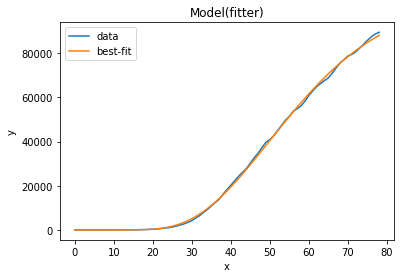

In [9]:
ax = plt.subplots()
result.plot_fit(datafmt="-", ax=ax)

In [10]:
print(result.best_values)

{'alpha': 1.2499999958154349, 'b': 13.004301428251674, 'r_s': 7.176954037847598, 'p_L_to_R': 1.4673594825337152e-16, 'p_I_to_C': 0.07157628955268654, 'p_C_to_D': 0.7999999999999999, 's': 0.004611660580559406}


# Let's make predictions for next month (30 days)

In [11]:
cases = covid_data[covid_data["Location"] == "US"][::-1]

dates = cases[cases["Value"]>0]["Date"].reset_index(drop=True)
first_date = dates[0]

full_days = len(y_data) + 30

x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")

predict_range = full_days - len(y_data)

forecast = Model(full_days, agegroup_lookup["US"], beds_lookup["United States"], **result.best_values)

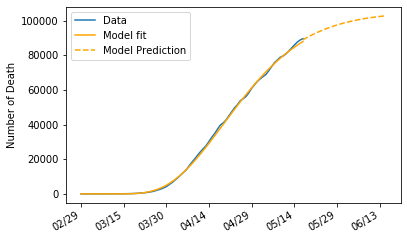

In [12]:
death_projection = forecast[7]
fig, ax = plt.subplots()

ax.plot(x_data, y_data, label="Data")
ax.plot(x_data, death_projection[:len(y_data)], color="orange", label="Model fit")
ax.plot(np.arange(x_data[-1],x_data[-1]+predict_range), death_projection[len(y_data):], 
         "--", color="orange", label="Model Prediction")

label_idx = np.arange(0, len(x_ticks), 15)
labels = x_ticks[label_idx].strftime("%m/%d")
location = np.arange(0, len(death_projection))
label_location = location[label_idx]

ax.set_xticks(label_location)
ax.set_xticklabels(labels, rotation=45)

ax.set_ylabel("Number of Death")
ax.legend()
fig.autofmt_xdate()
plt.show()

## 

In [13]:
def plotter(t, S, E, L, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None:
      print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")


    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        # ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, L, 'm', alpha=0.7, linewidth=2, label='Latent')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'c', alpha=0.7, linewidth=2, label='Critical')
        # ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        # ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, L, 'm', alpha=0.7, linewidth=2, label='Latent')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'c', alpha=0.7, linewidth=2, label='Critical')
        # ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()


    ax.title.set_text('SELICRD Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    f = plt.figure(figsize=(20,4))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

 
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(delta*E[:i]) if sum(delta*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();

Prediction for United States
percentage going to ICU: 7.157628955268653; percentage dying in ICU: 80.0


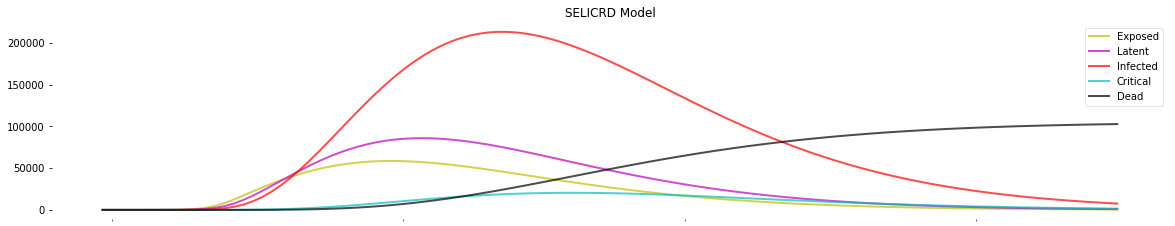

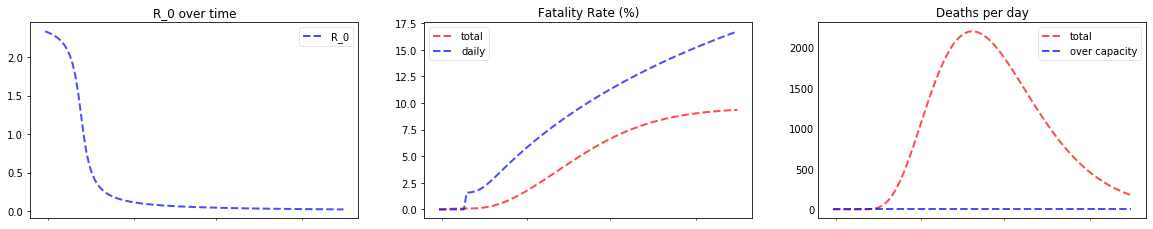

In [14]:
print("Prediction for United States")
plotter(*Model(full_days, agegroup_lookup["US"], beds_lookup["United States"], **result.best_values), x_ticks=x_ticks);
